In [8]:
import pandas as pd
import streamlit as st
import sqlite3
import matplotlib.pyplot as plt
import altair as alt
import sys
sys.path.insert(0, '.')
from utils import *
import numpy as np

In [2]:
class DbConn:

    def __init__(self) -> None:
        self.conn = sqlite3.connect("../data/latest.db") 

    def execute_sql(self, query:str, params:dict = None, return_df:bool = True): 

        cur = self.conn.cursor() 
        try:
            if params is not None:
                cur.execute(query, params) 
            else:
                cur.execute(query) 
            if return_df:
                column_names = [col[0] for col in cur.description] 
                query_data = cur.fetchall() 
                query_df = pd.DataFrame.from_records(query_data, columns=column_names) 
                res = query_df 

            return res 
        finally:
            cur.close() 

    def commit(self):
        self.conn.commit() 
        self.conn.close() 

def getLvl1Data():
    
    conn = DbConn()

    query = f"""
            SELECT t.*,
                l.administrative_area_level,
                l.administrative_area_level_1,
                l.administrative_area_level_2,
                l.administrative_area_level_3,
                l.latitude,
                l.longitude,
                l.population
            FROM timeseries t 
            LEFT JOIN location l on l.id = t.id
            WHERE l.administrative_area_level = 1;
            """ 
    
    df = conn.execute_sql(query=query, return_df=True)  

    # Convert date column to datetime and get the date 
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).date())

    return df

def getLvl2Data():
    
    conn = DbConn()

    query = f"""
            SELECT t.*,
                l.administrative_area_level,
                l.administrative_area_level_1,
                l.administrative_area_level_2,
                l.administrative_area_level_3,
                l.latitude,
                l.longitude,
                l.population
            FROM timeseries t 
            LEFT JOIN location l on l.id = t.id
            WHERE l.administrative_area_level = 2;
            """ 
    
    df = conn.execute_sql(query=query, return_df=True)  
    # Convert date column to datetime and get the date 
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).date())

    st.session_state['downloaded_lvl2_data'] = True

    return df


In [3]:
def epidemiological_features():
    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']
    return epidemiological_features 
    
def get_feature_time_series_lvl_1(df:pd.DataFrame, feature:str, administrative_area_level_1:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 1 and administrative_area_level_1 == @administrative_area_level_1')

    df = df[['date', feature]] 

    df['date'] = pd.to_datetime(df['date'])

    df = df.set_index('date')

    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df 

def get_feature_time_series_lvl_2(df:pd.DataFrame, feature:str, administrative_area_level_2:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 2 and administrative_area_level_2 == @administrative_area_level_2')

    df = df[['date', feature]] 

    df = df.set_index('date')

    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df  

def get_feature_time_series_lvl_3(df:pd.DataFrame, feature:str, administrative_area_level_3:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 3 and administrative_area_level_3 == @administrative_area_level_3')

    df = df[['date', feature]] 

    df = df.set_index('date')


    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df 

### Transformacoes

In [7]:
def log_transform(time_series: pd.Series):
    # remove zeros
    time_series = time_series.replace(0, np.nan).dropna()
    return np.log(time_series).dropna()

## Previsao do numero de mortes no Brasil

In [4]:
df = getLvl1Data()

In [5]:
mortes_br = get_feature_time_series_lvl_1(df, feature="deaths", administrative_area_level_1="Brazil")

<Axes: xlabel='date'>

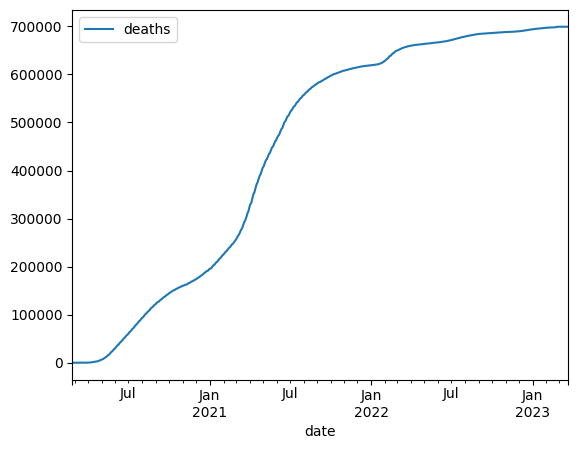

In [9]:
mortes_br.plot()

transformacao log

In [13]:
mortes_br['log_deaths'] = log_transform(mortes_br['deaths'])
mortes_br['log_deaths'] = mortes_br['log_deaths'].fillna(0)

<Axes: xlabel='date'>

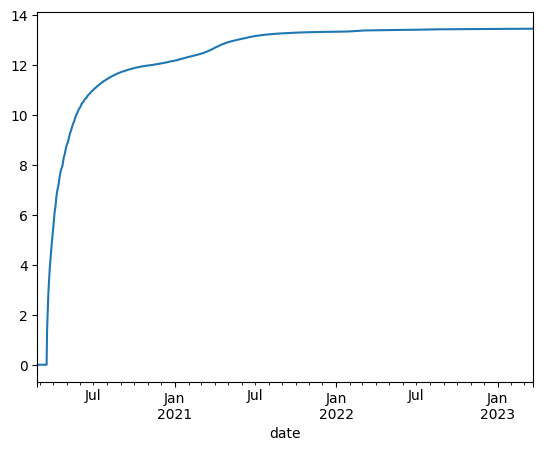

In [15]:
mortes_br['log_deaths'].plot()

Log and differencing 


In [23]:
mortes_br['log_diff1_deaths'] = mortes_br['log_deaths'].diff()
mortes_br['log_diff2_deaths'] = mortes_br['log_deaths'].diff(2)

<Axes: xlabel='date'>

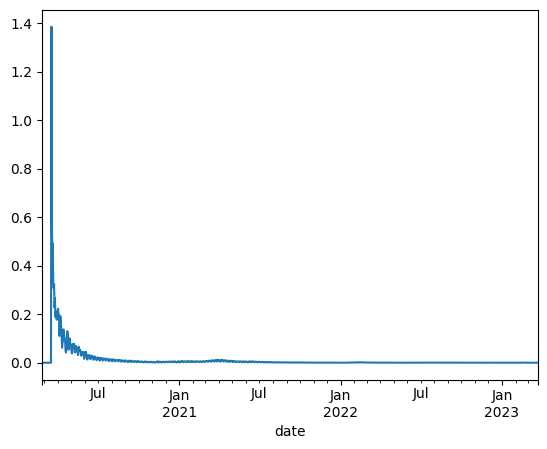

In [88]:
mortes_br['log_diff1_deaths'].plot()

### Box-Cox Test

In [65]:
from scipy.stats import boxcox
def boxcox_transform(time_series: pd.Series):
    """
    Apply Box-Cox transformation to a time series.

    Parameters:
    - time_series (pd.Series): Time series to transform.

    Returns:
    - pd.Series: Box-Cox transformed time series.
    """
    # Adicionar uma constante para evitar valores zero ou negativos
    ts_positive = time_series + 1 - time_series.min()

    # Tenta aplicar a transformação Box-Cox
    try:
        transformed, lam = boxcox(ts_positive['deaths'])
        return transformed
        return pd.Series(transformed, index=ts_positive.index), lam
    except Exception as e:
        raise(f'Erro ao aplicar a transformação Box-Cox: {e}')
        return time_series

In [66]:
mortes_br['box_cox_deaths'] = boxcox_transform(mortes_br)

log-log transformation

In [72]:
mortes_br['log_log_deaths'] = log_transform(mortes_br['log_deaths'])
mortes_br['log_log_deaths'].fillna(0, inplace=True)

log-log-diff transformation

In [82]:
mortes_br['log_log_diff_deaths'] = mortes_br['log_log_deaths'].diff()

sqrt transformation

In [83]:
mortes_br['sqrt_deaths'] = np.sqrt(mortes_br['deaths'])

In [84]:
mortes_br

,deaths,log_deaths,log_diff1_deaths,log_diff2_deaths,box_cox_deaths,log_log_deaths,log_log_diff_deaths,sqrt_deaths
date,,,,,,,,
2020-02-25,0.0,0.000000,NaN,NaN,0.000000,0.000000,NaN,0.000000
2020-02-26,0.0,0.000000,0.0,NaN,0.000000,0.000000,0.0,0.000000
2020-02-27,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
2020-02-28,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
2020-02-29,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...
2023-03-19,699310.0,13.457849,0.0,0.0,6194.916143,2.599563,0.0,836.247571
2023-03-20,699310.0,13.457849,0.0,0.0,6194.916143,2.599563,0.0,836.247571
2023-03-21,699310.0,13.457849,0.0,0.0,6194.916143,2.599563,0.0,836.247571


<Axes: xlabel='date'>

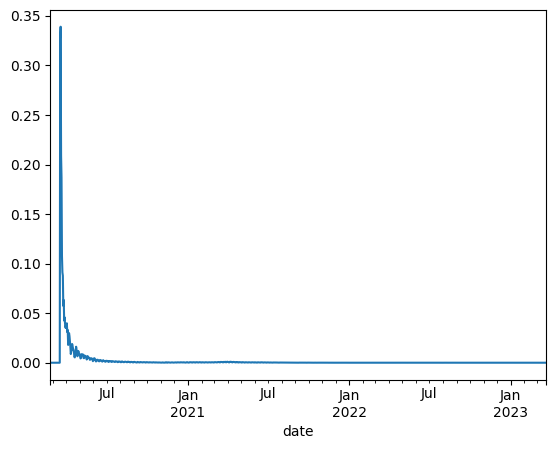

In [79]:
mortes_br['log_log_diff_deaths'].plot()

<Axes: xlabel='date'>

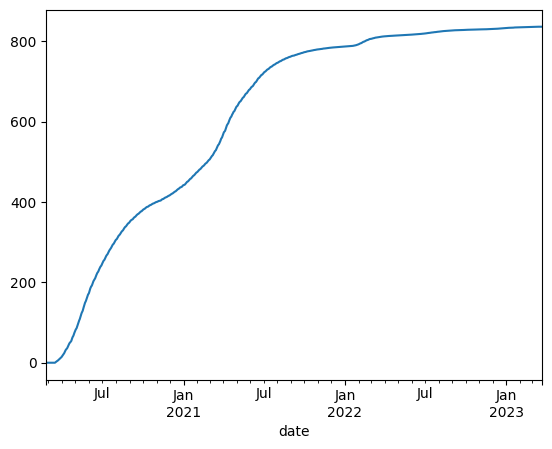

In [85]:
mortes_br['sqrt_deaths'].plot()

### Testing staionarity 

In [22]:
from statsmodels.tsa.stattools import adfuller

# ADF test
def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))


adf_test(mortes_br['log_diff1_deaths'][1:])

ADF Statistic:  -19.58466581361388
P-Value:  0.0
Critical Values:
	1%: -3.44
	5%: -2.86
	10%: -2.57


Autocorrelacao e autocorrelacao parcial

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_autocorrelation(time_series, lags=None):
    """
    Plot the autocorrelation of a time series.

    Parameters:
    - time_series (pd.Series): Time series for autocorrelation plotting.
    - lags (int): Number of lags to include in the plot (default is None).

    Returns:
    - None
    """


    # time_series = time_series.set_index('Data')

    if lags is not None:
        fig, ax = plt.subplots(figsize=(6,2))
        ax.set_xlabel("Lags")
        plot_acf(time_series, lags, auto_ylims=True, ax=ax, title=f'Autocorrelação com Lag {lags}')
        # st.pyplot(fig, clear_figure=True, use_container_width=False)
    else:
        fig , ax = plt.subplots(figsize=(5,3))
        ax.set_xlabel("Lags")
        plot_acf(time_series, auto_ylims=True, ax=ax, title = "Autocorrelação")
        # st.pyplot(fig, clear_figure=True, use_container_width=True) 

def plot_partial_autocorrelation(time_series, lags=None, fig_size=(10,8)):
    """
    Plot the partial autocorrelation of a time series.

    Parameters:
    - time_series (pd.Series): Time series for partial autocorrelation plotting.
    - lags (int): Number of lags to include in the plot (default is None).

    Returns:
    - None
    """

    if lags is not None:
        fig, ax = plt.subplots(figsize=(5,3))
        ax.set_xlabel("Lags")
        plot_pacf(time_series, lags=lags, auto_ylims=True, ax=ax, title=f'Autocorrelação Parcial com {lags} diferença')
        # st.pyplot(fig, clear_figure=True, use_container_width=False)
    else:
        fig, ax = plt.subplots(figsize=(5,3))
        ax.set_xlabel("Lags")
        plot_pacf(time_series, auto_ylims=True, ax=ax, title="Autocorrelação Parcial")
        # st.pyplot(fig, clear_figure=True, use_container_width=True)


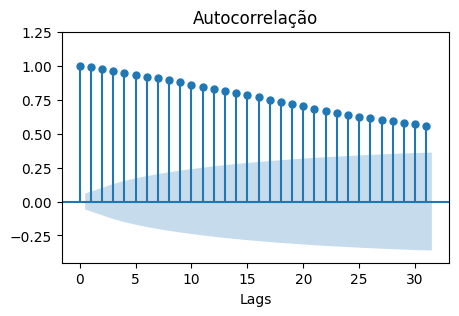

In [40]:
plot_autocorrelation(mortes_br['log_deaths'])

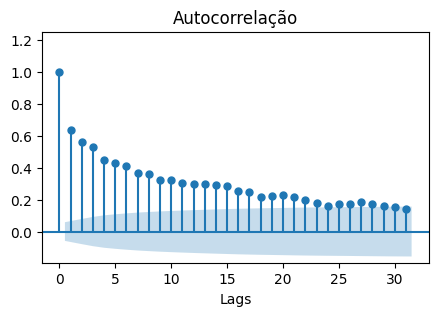

In [42]:
plot_autocorrelation(mortes_br['log_diff1_deaths'][1:])

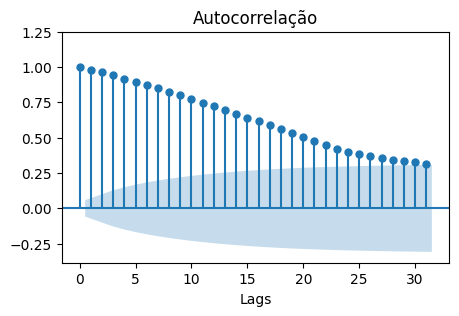

In [75]:
plot_autocorrelation(mortes_br['log_log_deaths'])

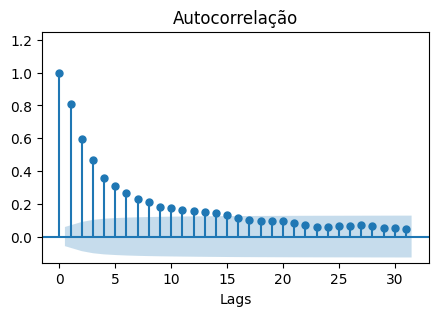

In [81]:
plot_autocorrelation(mortes_br['log_log_diff_deaths'][1:])

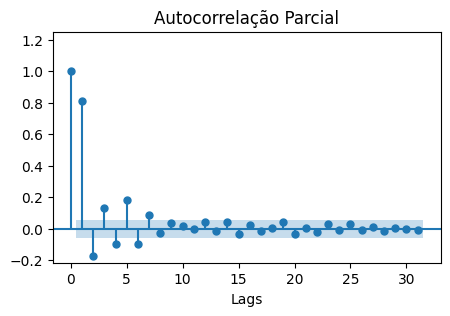

In [86]:
plot_partial_autocorrelation(mortes_br['log_log_diff_deaths'][1:])

## Série Diferenciada

In [89]:
mortes_br_diff = mortes_br['deaths'].diff()

<Axes: xlabel='date'>

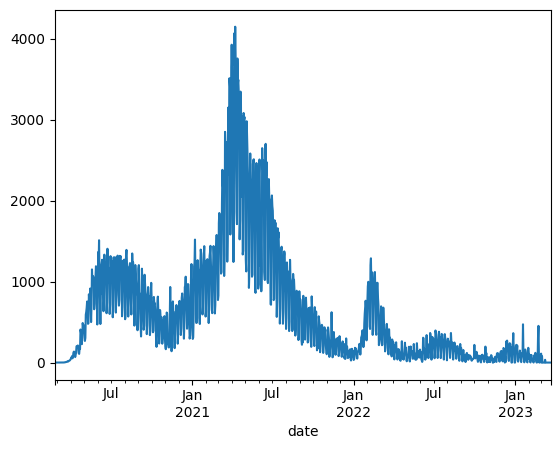

In [90]:
mortes_br_diff.plot()

### Log da serie diferenciada

In [91]:
mortes_br_diff_log = np.log(mortes_br_diff)

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='date'>

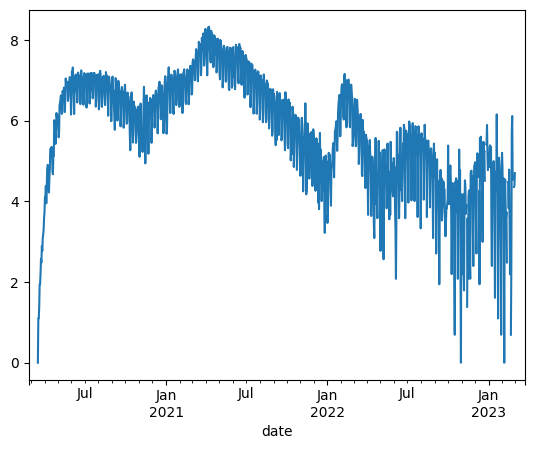

In [92]:
mortes_br_diff_log.plot()

### Primeira diferença da serie diária

In [96]:
mortes_br_diff_diff = mortes_br_diff.diff()

### Série diferenciada

Tendencia removida

<Axes: xlabel='date'>

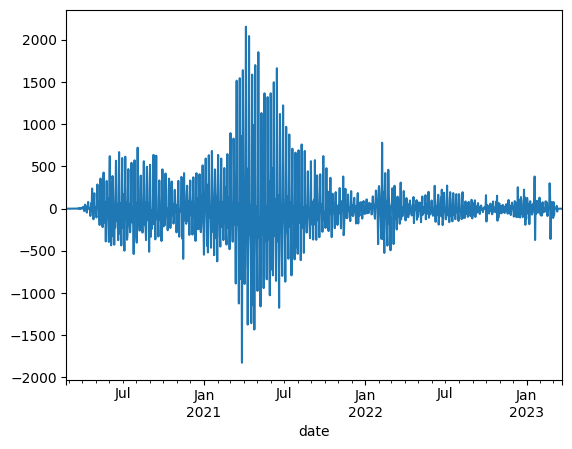

In [97]:
mortes_br_diff_diff.plot()

In [102]:
mortes_br_diff_diff = pd.DataFrame(mortes_br_diff_diff)

In [110]:
mortes_br_diff_diff_7diff = mortes_br_diff_diff['deaths'].diff(7)
mortes_br_diff_diff_7diff = pd.DataFrame(mortes_br_diff_diff_7diff)

### Serie diaria nao cumulativa

In [116]:
mortes_br_nao_cumulativo = mortes_br_diff

mortes_br_sem_tendencia = mortes_br_diff.diff() 

mortes_br_sem_sazonalidade = mortes_br_sem_tendencia.diff(7)

<Axes: xlabel='date'>

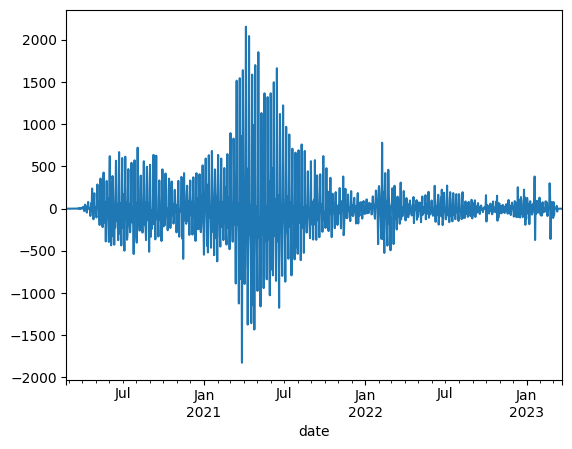

In [115]:
mortes_br_sem_tendencia.plot()

<Axes: xlabel='date'>

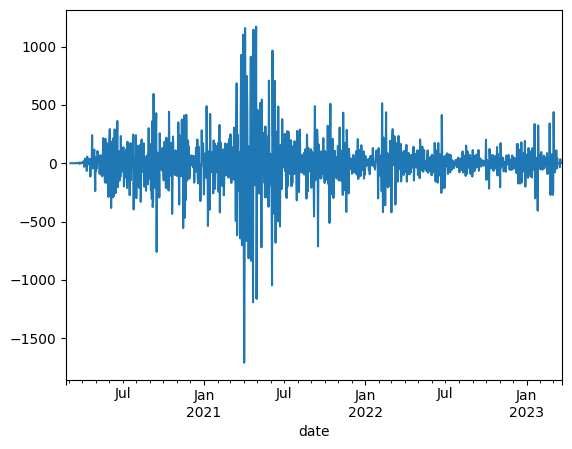

In [117]:
mortes_br_sem_sazonalidade.plot()

### Decomposition

In [120]:
mortes_br_sem_sazonalidade.fillna(0, inplace=True)

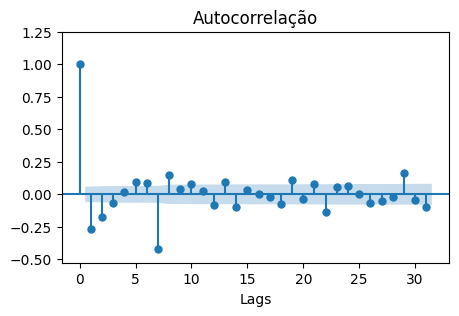

In [121]:
plot_autocorrelation(mortes_br_sem_sazonalidade)

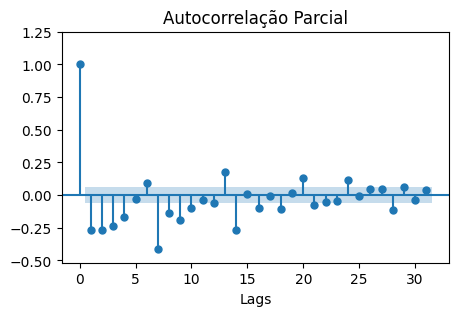

In [122]:
plot_partial_autocorrelation(mortes_br_sem_sazonalidade)